In [19]:
import typing
import torch
from torch import nn
import numpy as np
import numpy.typing as npt

from utils import config_parser, load_blender, show_img, find_POI, img2mse, load_llff_data
from nerf_helpers import load_nerf
from render_helpers import render, to8b, get_rays
from scipy.spatial.transform import Rotation as R
import imageio
from tqdm import tqdm

import os
import json
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Render Samples

In [20]:
trans_t = lambda t: np.array([
        [1, 0, 0, t[0]],
        [0, 1, 0, t[1]],
        [0, 0, 1, t[2]],
        [0, 0, 0, 1]])

def sample_from_sphere_uniform(ndim: int, r: float) -> npt.NDArray[typing.Any]:
    """Samples a random point on the `ndim`-dimensional sphere of radius `r`.
    
    Exploits that a multivariate normal distribution is spherical in $\mathbb R^n$, then normalizes and scales by `r`.
    """
    out = np.zeros(ndim)
    while np.linalg.norm(out) == 0:
        out = np.random.randn(ndim)

    out /= np.linalg.norm(out)
    out *= r
    return out


def get_random_pose(d_min: float=3, d_max: float=5, t_min: float=0, t_max: float=0.5, clamp_uh: bool=True) -> npt.NDArray[typing.Any]:
    """Returns the transformation matrix (in homogeneous coordinates) for a random 6D starting pose.
    The pose is defined by a 3D rotation and a 3D translation.
    The rotation is sampled uniformly on SO(3) or its subset which results in a viewpoint in the upper hemisphere if `clamp_uh` is True.
    The translation along the z-axis (view axis, equivalent to distance from object) is sampled uniformly from [`d_min`, `d_max`].
    Translations along the x- and y-axis (orthogonal to view axis) are sampled uniformly from [`t_min`, `t_max`].
    """
    # warnings.warn("Don't forget to seed numpy for reproducability when using this function.")
    # sample uniform rotation
    rotation = np.eye(4)
    rotation[:3, :3] = R.random().as_matrix()
    while clamp_uh and np.dot([0, 0, 1], np.dot(rotation[:3, :3], [0, 0, 1])) < 0:
        rotation[:3, :3] = R.random().as_matrix()

    # sample translation
    z = np.random.uniform(d_min, d_max, 1)
    xy = np.random.uniform(t_min, t_max, 2)
    translation = trans_t(np.concatenate([xy, z]))

    # rotate around origin, then translate
    pose = rotation @ translation
    return torch.Tensor(pose)



In [21]:
from dataclasses import dataclass

@dataclass
class Args:
    netdepth=8
    netwidth=256
    netdepth_fine=8
    netwidth_fine=256
    chunk=1024*32
    netchunk=1024*64

    model_name='lego'
    data_dir = './data/nerf_synthetic/'
    ckpt_dir = './ckpts'
    dataset_type='blender'
    obs_img_num=1
    
    use_viewdirs=True
    N_importance=64
    N_samples=64
    white_bkgd=True
    
    i_embed=0
    perturb=0.
    raw_noise_std=0.
    lindisp=True
    multires=10
    multires_views=4


args = Args()


In [12]:
testsavedir = './image-to-pos/lego1'

## Compare rendered and saved image

Found ckpts ./ckpts/lego.tar
Reloading from ./ckpts/lego.tar
Not ndc!


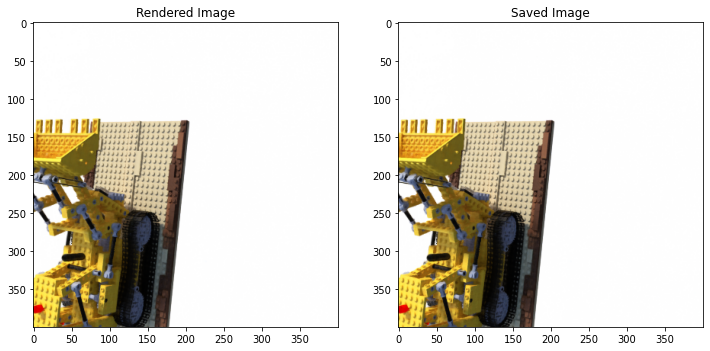

In [32]:
from PIL import Image
import json

FRAME_ID = 1

with open('image-to-pos/lego1/transforms.json', 'r') as f:
    transforms_file = json.load(f)

frame = transforms_file['frames'][FRAME_ID]
torch.set_default_tensor_type('torch.cuda.FloatTensor')
pose = torch.Tensor(frame['transform_matrix']).cuda()

H, W = 400, 400
camera_angle_x = 0.6911112070083618
focal = .5 * W / np.tan(.5 * camera_angle_x)


render_kwargs = load_nerf(args, device)
bds_dict = {
    'near': 2.,
    'far': 6.5,
}
render_kwargs.update(bds_dict)


rays_o, rays_d = get_rays(H, W, focal, pose)  # (H, W, 3), (H, W, 3)
batch_rays = torch.stack([rays_o, rays_d], 0)

rgb, disp, acc, extras = render(H, W, focal, chunk=args.chunk, rays=batch_rays,
                                verbose=0 < 10, retraw=True,
                                **render_kwargs)
rgb = rgb.cpu().detach().numpy()
rgb8 = to8b(rgb)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title('Rendered Image')
plt.imshow(rgb8)
plt.subplot(1, 2, 2)
with open(f'image-to-pos/lego1/{frame["file_path"]}.png', "rb") as f:
    img = Image.open(f)
    img = img.convert("RGB")
plt.title('Saved Image')
plt.imshow(img)
plt.show()

## Render

In [31]:
random_state = np.load(os.path.join(testsavedir, 'random_state.npy'), allow_pickle=True).tolist()
np.random.set_state(random_state)

In [24]:
np.save(os.path.join(testsavedir, 'random_state.npy'), np.asanyarray(np.random.get_state(), dtype=object))

In [ ]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
H, W = 400, 400
camera_angle_x = 0.6911112070083618
focal = .5 * W / np.tan(.5 * camera_angle_x)

with open(os.path.join(args.data_dir + str(args.model_name) + "/obs_imgs/", 'transforms.json'), 'r') as fp:
    meta = json.load(fp)
frames = meta['frames']

obs_img_pose = np.array(frames[args.obs_img_num]['transform_matrix']).astype(np.float32)

d = np.linalg.norm(obs_img_pose[:3, 3:])

delta_d = (-1, 2)

render_kwargs = load_nerf(args, device)
bds_dict = {
    'near': 2.,
    'far': 6.5,
}
render_kwargs.update(bds_dict)

poses = [ get_random_pose(d+delta_d[0], d+delta_d[1], 0., 1., clamp_uh=True).cuda() for _ in range(10_000) ]
print('Save poses')
with open(os.path.join(testsavedir, 'transforms.json'), 'w') as f:
    pc = [p.cpu().numpy().tolist() for p in poses]
    json.dump(pc, f, indent=2)

# plt.figure(figsize=(20, 10))
print(f'Render {len(poses)} images')
for i, pose in tqdm(enumerate(poses), total=len(poses)):


    rays_o, rays_d = get_rays(H, W, focal, pose)  # (H, W, 3), (H, W, 3)
    batch_rays = torch.stack([rays_o, rays_d], 0)

    rgb, disp, acc, extras = render(H, W, focal, chunk=args.chunk, rays=batch_rays,
                                    verbose=0 < 10, retraw=True,
                                    **render_kwargs)
    rgb = rgb.cpu().detach().numpy()
    rgb8 = to8b(rgb)
    filename = os.path.join(testsavedir, str(i)+'.png')
    imageio.imwrite(filename, rgb8)

#     plt.subplot(2, 5, i+1)
#     plt.imshow(rgb)

# plt.show()

# Train

In [2]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)

class ImageToPosNet(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        self.conv0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.resblock0 =  ResBlock(64, 64, downsample=False)
        self.resblock1 =  ResBlock(64, 64, downsample=False)

        self.layer2 = nn.Sequential(
            ResBlock(64, 128, downsample=True),
            ResBlock(128, 128, downsample=False)
        )

        self.layer3 = nn.Sequential(
            ResBlock(128, 256, downsample=True),
            ResBlock(256, 256, downsample=False)
        )


        self.layer4 = nn.Sequential(
            ResBlock(256, 512, downsample=True),
            ResBlock(512, 512, downsample=False)
        )

        self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Sequential(
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 16)
        )
        # self.zer = torch.ones((4,4))

    def _vec2ss_matrix(self, vector):  # vector to skewsym. matrix

        ss_matrix = torch.zeros((3,3))
        ss_matrix[0, 1] = -vector[2]
        ss_matrix[0, 2] = vector[1]
        ss_matrix[1, 0] = vector[2]
        ss_matrix[1, 2] = -vector[0]
        ss_matrix[2, 0] = -vector[1]
        ss_matrix[2, 1] = vector[0]

        return ss_matrix
    
    def camera_transform(self, x: torch.Tensor):

        if len(x.shape) == 2:
            res = torch.zeros((x.shape[0], 4, 4)).to(x.get_device())
            for batch_idx in range(x.shape[0]):
                res[batch_idx] = self.camera_transform(x[batch_idx])
            return res

        w = x[:3]
        v = x[3:6]
        theta = x[6]

        exp_i = torch.zeros((4,4))
        w_skewsym = self._vec2ss_matrix(w)
        exp_i[:3, :3] = torch.eye(3) + torch.sin(theta) * w_skewsym + (1 - torch.cos(theta)) * torch.matmul(w_skewsym, w_skewsym)
        exp_i[:3, 3] = torch.matmul(torch.eye(3) * theta + (1 - torch.cos(theta)) * w_skewsym + (theta - torch.sin(theta)) * torch.matmul(w_skewsym, w_skewsym), v)
        exp_i[3, 3] = 1.

        return exp_i



    def forward(self, x):
        
        x = self.conv0(x)
        x = self.resblock0(x)
        x = self.resblock1(x)

        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        # return x

        # pose = self.camera_transform(x)


        return x.reshape(-1,4,4)


In [3]:
from typing import Any, Callable, List, Literal, Optional, Tuple, Type, Union, cast, overload
from glob import glob
from torch.utils.data import Dataset
from PIL import Image

class PoseDataset(Dataset):

    def __init__(
        self,
        root: Optional[str] = None,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
    ):
        # self.samples = glob(os.path.join(''))
        self.root = root
        self.transform = transform
        self.target_transform = target_transform
    
        with open(os.path.join(self.root, 'transforms.json'), 'r') as f:
            targets = json.load(f)
        self.samples = []
        for i, target in enumerate(targets):
            filepath = os.path.join(root, f'{i + 872}.png')
            self.samples.append((filepath, torch.Tensor(target)))

    def loader(self, path: str) -> Image.Image:
        # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
        with open(path, "rb") as f:
            img = Image.open(f)
            return img.convert("RGB")

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

    def __len__(self):
        return len(self.samples)

In [4]:
import pickle
class InMemoryDataset(Dataset):

    def __init__(self, path):
        with open(path, 'rb') as f:
            self.data = pickle.load(f)
    
    def __getitem__(self, index: Any) -> Tuple[torch.Tensor, int]:
        return self.data[index]
    
    def __len__(self):
        return len(self.data)
    
    @staticmethod
    def create_dataset_file(dataset: Dataset, path: str):
        from tqdm import tqdm
        res = {}
        for idx, data in tqdm(enumerate(dataset), total=len(dataset), desc="Loading images"):
            res[idx] = data
        with open(path, 'wb') as f:
            pickle.dump(res, f)

In [5]:
import torchvision

# ds = PoseDataset('./image-to-pos/lego1', torchvision.transforms.ToTensor())
ds = InMemoryDataset('./image-to-pos/lego1.pickle')
from torch.utils.data import DataLoader

training_loader = DataLoader(
    ds, 
    batch_size=32, 
    shuffle=True, 
    num_workers=2, 
)

In [6]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
model = ImageToPosNet(3)
model.cuda()

loss_fn = torch.nn.MSELoss()

# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch_index in range(500):
    print(f'Epoch {epoch_index}')
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in tqdm(enumerate(training_loader), total=len(training_loader)):
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # print('TARGET', labels)
        # print('OUTPUT', outputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 10 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            # tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
    
    print('Last Epoch: {} - Loss: {}'.format(epoch_index, running_loss / i))


Epoch 0


  3%|▎         | 10/286 [00:12<04:55,  1.07s/it]

  batch 10 loss: 1.5730361580848693


  7%|▋         | 20/286 [00:22<04:21,  1.02it/s]

  batch 20 loss: 1.3078449606895446


 10%|█         | 30/286 [00:32<04:12,  1.02it/s]

  batch 30 loss: 1.2117674469947814


 14%|█▍        | 40/286 [00:42<03:59,  1.03it/s]

  batch 40 loss: 1.2278289556503297


 17%|█▋        | 50/286 [00:51<03:52,  1.02it/s]

  batch 50 loss: 1.1369442820549012


 21%|██        | 60/286 [01:01<03:41,  1.02it/s]

  batch 60 loss: 1.1261570274829864


 24%|██▍       | 70/286 [01:12<03:53,  1.08s/it]

  batch 70 loss: 1.1358397841453551


 28%|██▊       | 80/286 [01:22<03:27,  1.01s/it]

  batch 80 loss: 1.0891294598579406


 28%|██▊       | 81/286 [01:23<03:31,  1.03s/it]


KeyboardInterrupt: 

In [6]:
InMemoryDataset.create_dataset_file(ds, './image-to-pos/lego1.pickle')

Loading images:  60%|██████    | 5480/9128 [00:55<00:36, 100.46it/s]

: 

: 

In [6]:
for i, data in enumerate(training_loader):
    break

9128